In [1]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import import_ipynb
import model
import copy
import argparse
from torch import FloatTensor



importing Jupyter notebook from model.ipynb


In [2]:
#load model and define parameters
feat_dim = 2048 
cls_dim = 85
enc_hdim1 = 512
enc_hdim2 = 512 
zdim = 50 
dec_hdim1 = 512 
disc_hdim1 = 512

model = model.GZSL(feat_dim, cls_dim, enc_hdim1, enc_hdim2, zdim, dec_hdim1, disc_hdim1)
model.load_state_dict(torch.load('models/gzsl_train_rerun.bin'))

In [3]:
#get train and test data for SVM
testData = np.load(open('testData', 'rb'))
testLabels = np.load(open('testLabels', 'rb'))
testLabelVectors = np.load(open('testAttributes' , 'rb'))
seentestData = np.load(open('seentestData', 'rb'))
seentestLabels = np.load(open('seentestLabels', 'rb'))
seentestLabelVectors = np.load(open('seentestLabelVectors' , 'rb'))
fp = open('classes.txt' ,'r')
allclasses = [x.strip().split('\t')[1] for x in fp.readlines()]
fp.close()
allLabels = {}
count = 0 
for cl in allclasses:
    allLabels[cl] = count
    count = count + 1

testClasses = [allLabels[x.split()[0]] for x in open('testclasses.txt', 'r').readlines()]

fp_attr = open('predicate-matrix-continuous.txt' ,'r')
ATTR   =[[float(a) for a in x.strip().split(' ') if a] for x in fp_attr.readlines()]
ATTR = torch.from_numpy(np.array(ATTR))
ATTR = ATTR.type(torch.FloatTensor)
allClassLabels = list(allLabels.values())
test_cls_attr = ATTR[testClasses]

In [4]:
#generate images for seen and unseen classes
gen_num = 10
batch_size = 1
gen_img = FloatTensor()
gen_labels = np.array([])
gen_img_t = FloatTensor()
gen_labels_t = np.array([])
for param in model.parameters():
    param.requires_grad = False
for k,cls in enumerate(ATTR):
    cls = cls.repeat(1,batch_size).view(batch_size,85)
    label = [allClassLabels[k]]*batch_size
    for i in range(gen_num//batch_size):
        cur_x, cur_attr  = model.generate_images(batch_size, cls)
        if k in testClasses:
            gen_img_t = torch.cat((gen_img_t,cur_x), 0)
            gen_labels_t = np.array(np.hstack([gen_labels_t, label]) if gen_labels_t.size else label)
        gen_img = torch.cat((gen_img,cur_x), 0)        
        gen_labels = np.array(np.hstack([gen_labels, label]) if gen_labels.size else label)
gen_labels = np.array(gen_labels)
gen_img = np.array(gen_img)

In [5]:
from sklearn.svm import LinearSVC
trainLabels = np.load(open('trainLabels' , 'rb'))

weight = {}
for i in np.unique(gen_labels):
    if i in np.unique(trainLabels):
        weight[i] = 1.0
    else:
        weight[i] = 0.05

In [6]:
clf3 = LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling = 1, loss='hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001, verbose=0)
clf3.fit(gen_img_t, gen_labels_t)
predictions3 = clf3.predict(testData)
predictions3 = np.array(predictions3)
test_labels = np.array(testLabels)    

In [7]:
def getAvgClassAccuracy(predictions, testLabels):
    dict_correct = {}
    dict_total = {}
    allTestClasses = np.unique(testLabels)
    for ii in allTestClasses:
        dict_total[ii] = 0 
        dict_correct[ii] = 0

    for ii in range(0,testLabels.shape[0]):
        if(testLabels[ii] == predictions[ii]):
            dict_correct[testLabels[ii]] = dict_correct[testLabels[ii]] + 1
        dict_total[testLabels[ii]] = dict_total[testLabels[ii]] + 1 

    avgAcc = 0.0
    for ii in allTestClasses:
        avgAcc = avgAcc + (dict_correct[ii]*1.0)/(dict_total[ii])

    avgAcc = avgAcc/len(allTestClasses) 
    print("The average per-class accuracy of my svm model is {:.2f}".format(avgAcc*100))

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


The average per-class accuracy of my svm model is 50.20


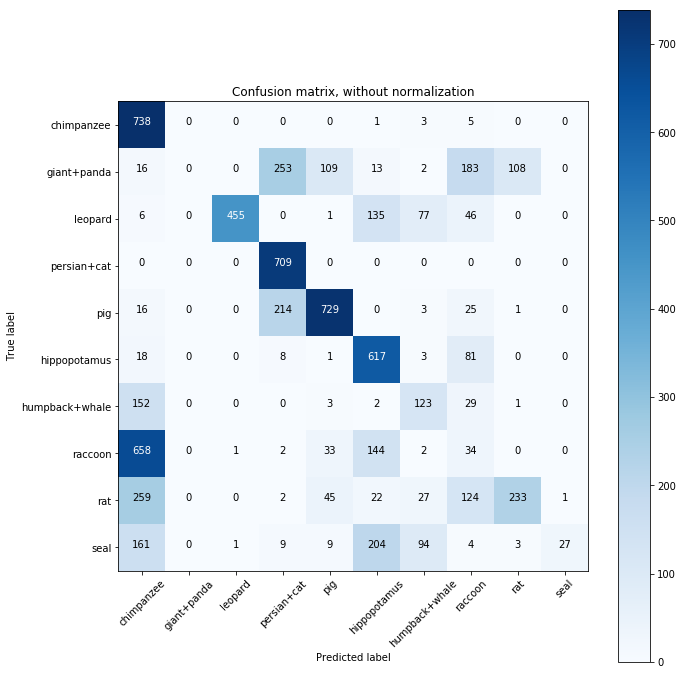

In [9]:
#get accuracy on unseen examples
accuracy = sum(np.array(predictions3) == test_labels) / float(testData.shape[0])
#print("The accuracy of my svm model is {:.2f}".format(accuracy*100))
getAvgClassAccuracy(predictions3, testLabels)
names = [allclasses[i] for i in testClasses]
# Compute confusion matrix
cnf_matrix = confusion_matrix(testLabels, predictions3)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=names,
                      title='Confusion matrix, without normalization')
plt.show()

In [10]:
clf3 = LinearSVC(C=1.0, class_weight=weight, dual=True, fit_intercept=True,
     intercept_scaling = 1, loss='hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001, verbose=0)
clf3.fit(gen_img, gen_labels)

LinearSVC(C=1.0,
     class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.05, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 0.05, 14: 0.05, 15: 1.0, 16: 1.0, 17: 0.05, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 0.05, 24: 0.05, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.05, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 0.05, 39: 1.0, 40: 1.0, 41: 0.05, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0, 47: 0.05, 48: 1.0, 49: 1.0},
     dual=True, fit_intercept=True, intercept_scaling=1, loss='hinge',
     max_iter=100000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0)

In [11]:
#get accuracy on seen classes
predictions4 = clf3.predict(seentestData)
predictions4 = np.array(predictions4)
seen_test_labels = np.array(seentestLabels) 
accuracy = sum(np.array(predictions4) == seen_test_labels) / float(seentestData.shape[0])
#print("The accuracy of my svm model is {:.2f}".format(accuracy*100))
getAvgClassAccuracy(predictions4, seentestLabels)



The average per-class accuracy of my svm model is 70.54
